In [2]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import accuracy_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
# Data Preparation
datapath = '140k_dataset/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64
train_flow = image_gen.flow_from_directory(
    datapath + 'train/', target_size=(224, 224), batch_size=batch_size, class_mode='binary'
)
valid_flow = image_gen.flow_from_directory(
    datapath + 'valid/', target_size=(224, 224), batch_size=batch_size, class_mode='binary'
)
test_flow = image_gen.flow_from_directory(
    datapath + 'test/', target_size=(224, 224), batch_size=1, shuffle=False, class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20003 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [4]:
#plotting real and fake faces from dataset
def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = np.random.randint(20000)
    fig, ax = plt.subplots(3,3, figsize=(8,8))
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k = np.random.randint(20000)
    plt.suptitle(set_ + ' faces from train dataset')
    return plt

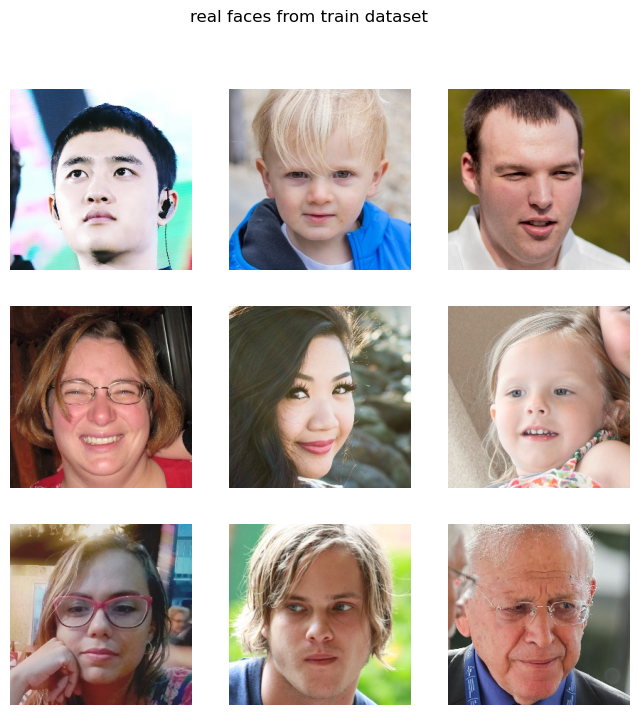

In [5]:
plot_img(datapath, 'real').show()

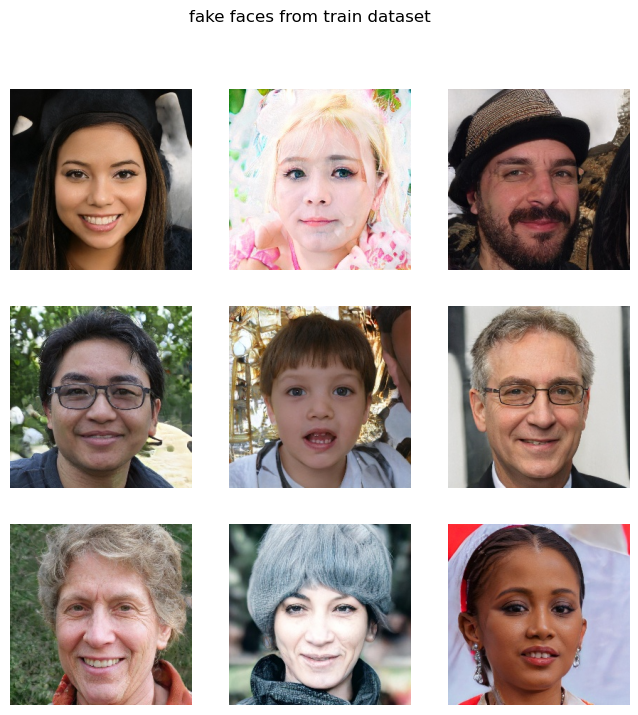

In [6]:
plot_img(datapath, 'fake').show()

In [2]:
# Base CNN Model Architecture
def create_cnn_model(input_shape):
    model = Sequential()

    # Initial Batch Normalization to normalize input
    model.add(layers.BatchNormalization(input_shape=input_shape))

    # First Convolutional Block: Conv2D -> MaxPooling -> BatchNorm
    model.add(layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())

    # Second Convolutional Block: Conv2D -> MaxPooling -> BatchNorm
    model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1)) # Dropout for regularization

    # Third Convolutional Block: Conv2D -> MaxPooling -> BatchNorm
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1)) 

    # Fourth Convolutional Block: Conv2D -> MaxPooling -> BatchNorm
    model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1)) 

    # Fifth Convolutional Block: Conv2D -> MaxPooling -> BatchNorm
    model.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    # Sixth Convolutional Block: Conv2D -> MaxPooling -> BatchNorm
    model.add(layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    # Final Convolutional Block: Conv2D -> MaxPooling -> BatchNorm
    model.add(layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    # Flatten the feature maps into a vector for classification
    model.add(layers.Flatten())

    # Output layer for binary classification with sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
# Create CNN Model
cnn_model = create_cnn_model((224, 224, 3))
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

/Users/prarthanarout/anaconda3/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train CNN Model with Model Checkpointing
history=cnn_model.fit(
    train_flow,
    epochs=6,
    validation_data=valid_flow,
    callbacks=[ModelCheckpoint(
        "saved-cnn-model.keras", 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max')], # Maximize validation accuracy during training
)

Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1105s 706ms/step - accuracy: 0.7078 - loss: 0.6063 - val_accuracy: 0.7596 - val_loss: 0.5249
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1204s 769ms/step - accuracy: 0.8435 - loss: 0.3533 - val_accuracy: 0.7597 - val_loss: 0.5874
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1318s 842ms/step - accuracy: 0.8995 - loss: 0.2400 - val_accuracy: 0.8407 - val_loss: 0.4027
Epoch 4/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1139s 727ms/step - accuracy: 0.9316 - loss: 0.1704 - val_accuracy: 0.8687 - val_loss: 0.3490
Epoch 5/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1291s 825ms/step - accuracy: 0.9515 - loss: 0.1232 - val_accuracy: 0.9470 - val_loss: 0.1347
Epoch 6/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1728s 1s/step - accuracy: 0.9646 - loss: 0.0920 - val_accuracy: 0.9525 - val_loss: 0.1209


In [ ]:
# Load the saved models
model_path = "/Users/prarthanarout/deep-fake-detection/saved-cnn-model.keras"
best_cnn_model = load_model(model_path)

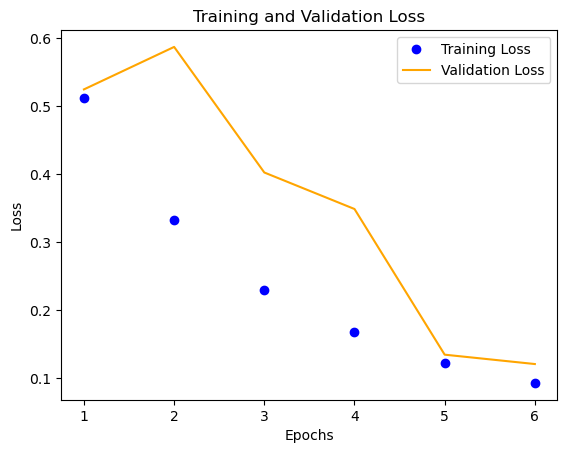

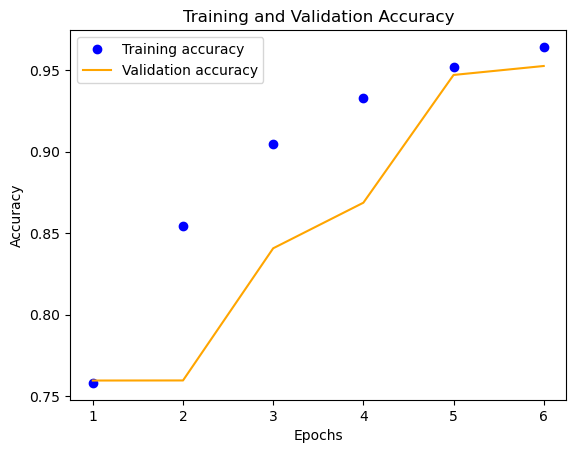

In [ ]:
# Extracting loss and accuracy data from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualization for Loss
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Visualization for Accuracy
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plotting Loss and Accuracy across epochs
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [ ]:
# Predicting on the test set and obtaining the actual labels
y_pred = cnn_model.predict(test_flow)
y_test = test_flow.classes

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 154s 8ms/step


Accuracy Score : 0.95255
Report : 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10000
           1       0.99      0.92      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



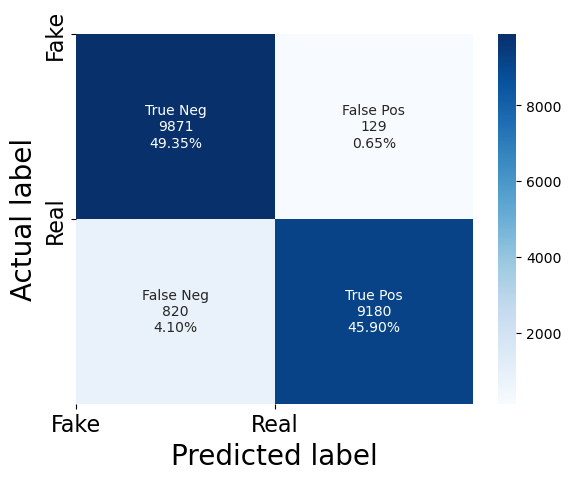

In [ ]:
# Generating confusion matrix and visualizing model performance
results = confusion_matrix(y_test, y_pred > 0.5) 

# Define group names, counts, and percentages for annotations
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in results.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in results.flatten()/np.sum(results)]

# Combine group names, counts, and percentages into labels for the heatmap
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2) # Reshape labels for 2x2 confusion matrix

# Create a heatmap for visualizing the confusion matrix
sns.heatmap(results, annot=labels, fmt='', cmap = 'Blues')
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)
plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)

# Print accuracy score and classification report
print('Accuracy Score :',accuracy_score(y_test, y_pred > 0.5))
print('Report : ')
print(classification_report(y_test, y_pred > 0.5))

In [ ]:
# Evaluate model using ROC-AUC and Average Precision scores
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.99508597
AP Score: 0.994996404260461


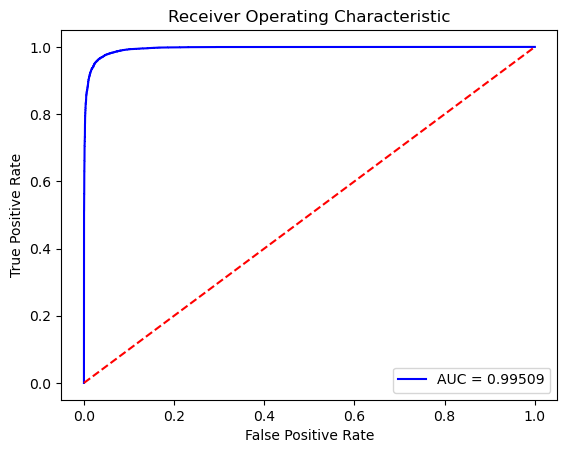

In [ ]:
# Plot ROC Curve and calculate AUC
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') # Diagonal line for chance level
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1/1 [==============================] - 0s 18ms/step


<module 'matplotlib.pyplot' from '/Users/prarthanarout/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

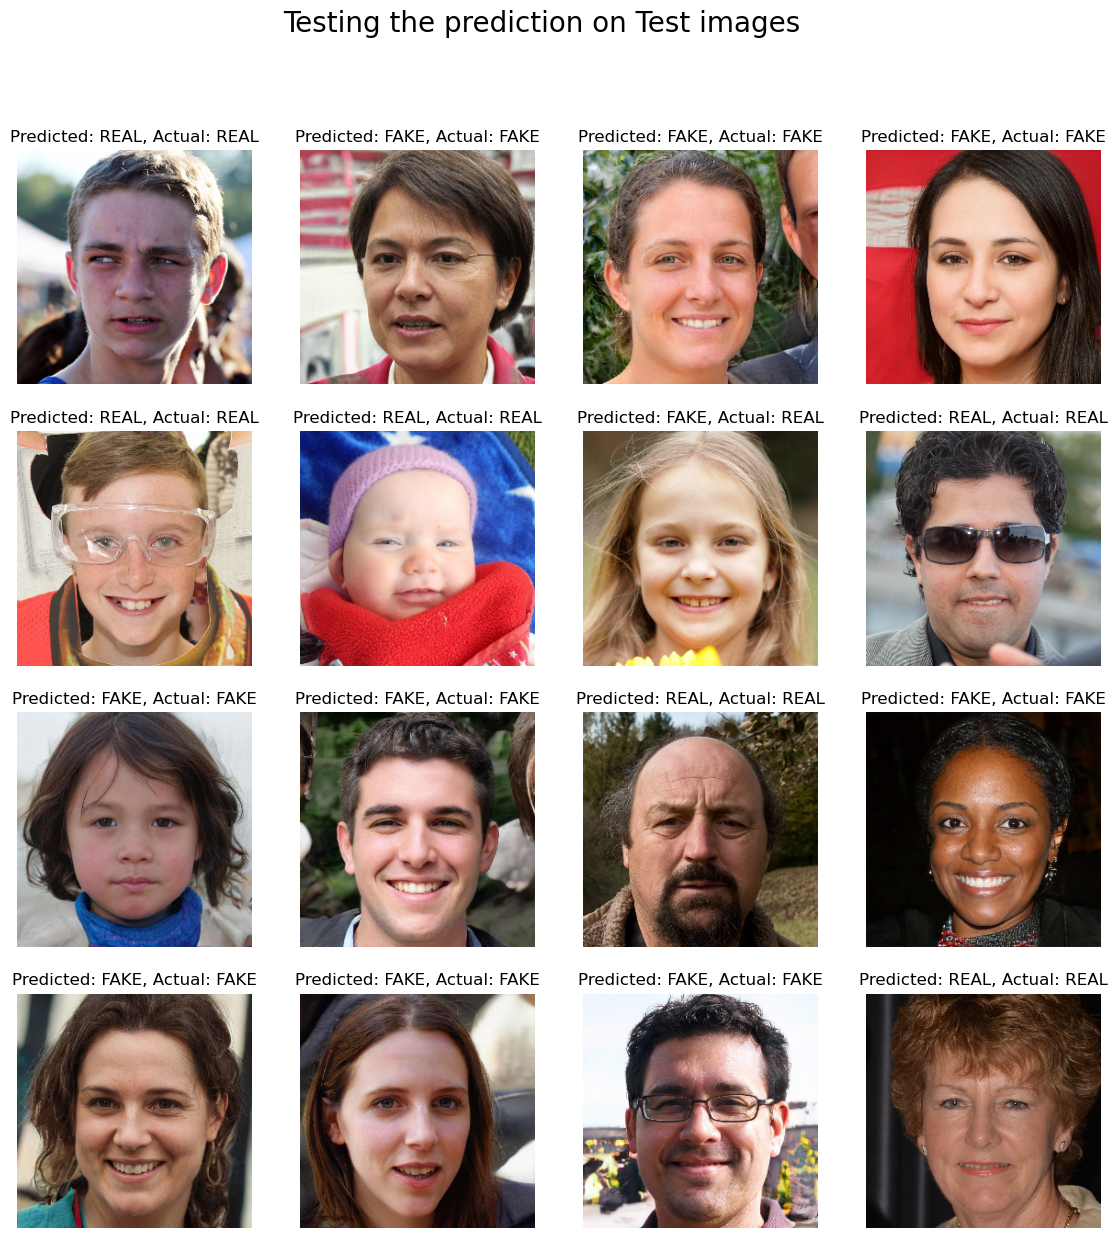

In [ ]:
# Display a grid of test images with their predicted and actual classes 
def predict_img_class():
    k = np.random.randint(20000)
    gridx = 4
    gridy = 4
    fig, ax = plt.subplots(gridx,gridy, figsize=(14,14))

    for j in range(gridx):
        for i in range(gridy):
            # Determine the actual class of the image (FAKE or REAL)
            if test_flow.classes[k] == 0:
                actual = "FAKE"
            else:
                actual = "REAL"  
                
            # Predict the class using the model    
            if model.predict(test_flow[k][0])[0][0]<0.5:
                prediction = "FAKE"
            else:
                prediction = "REAL"

            # Load the image from the dataset path
            datasetpath = test_flow.filenames[k]
            imgpath = datapath+'test/'+datasetpath
            img = load_img(imgpath) 

            # Display the image along with the predicted and actual labels         
            ax[j,i].imshow(img)
            ax[j,i].set_title(f"Predicted: {prediction}, Actual: {actual}",size = 12)
            ax[j,i].axis('off')
            k = np.random.randint(20000)

    fig.suptitle('Testing the prediction on Test images', size = 20)
    return plt

predict_img_class()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


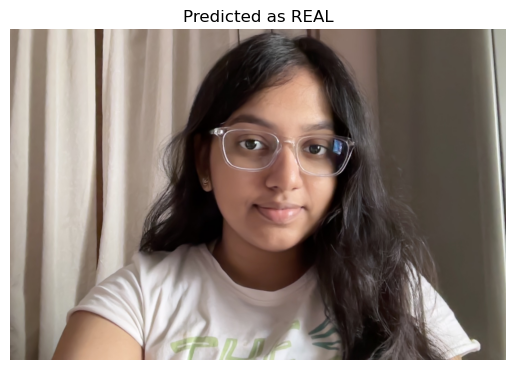

In [ ]:
# Real-Time Prediction with Live Photo
live_photo_path = "/Users/prarthanarout/deep-fake-detection/Photo on 05-11-24 at 11.33 AM.jpg"
live_photo = load_img(live_photo_path, target_size=(224, 224))
live_photo = img_to_array(live_photo) / 255.0
live_photo = np.expand_dims(live_photo, axis=0)

# Predict on Live Photo
live_prediction = best_cnn_model.predict(live_photo)

# Display Prediction Result
plt.imshow(mpimg.imread(live_photo_path))
plt.axis('off')
if live_prediction[0][0] < 0.5:
    prediction = "FAKE"
else:
    prediction = "REAL"

plt.title(f"Predicted as {prediction}")
plt.show()
